<a href="https://colab.research.google.com/github/plaban1981/Dphi_hackathon/blob/main/Copy_of_Data_Sprint_25_Flower_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Problem Statement  **Build a model to recognize the name of a flower**

## Download the images

In [ ]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1H0rJmSBmYQoWM2w2tqy-jmX0Y2Wg6k2v',
dest_path='content/flowers.zip',
unzip=True)

Unzipping...Done.


## Loading Libraries

In [ ]:
import pandas as pd # Data analysis and manipultion tool
import numpy as np # Fundamental package for linear algebra and multidimensional arrays
import tensorflow as tf # Deep Learning Tool
import os # OS module in Python provides a way of using operating system dependent functionality
import cv2 # Library for image processing
from sklearn.model_selection import train_test_split # For splitting the data into train and validation set
from sklearn.metrics import accuracy_score

#
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import cv2
import glob
from pathlib import Path
from fastai import *
from fastai.vision import *
import torch
from fastai.callbacks.hooks import *
import warnings
warnings.filterwarnings('ignore')

In [ ]:
test = pd.read_csv("/content/content/flowers/Testing_set_flower.csv")
test.head()

,filename
0,Image_1.jpg
1,Image_2.jpg
2,Image_3.jpg
3,Image_4.jpg
4,Image_5.jpg


In [ ]:
sub = pd.read_csv("/content/content/flowers/sample_submission.csv")
sub.head()

,prediction
0,sunflower
1,sunflower
2,sunflower
3,sunflower
4,sunflower


In [ ]:
import os
filename = []
label = []
for folder in os.listdir("/content/content/flowers/train"):
  folder_name = "/content/content/flowers/train/"+ folder
  for image in os.listdir(folder_name):
    filename.append(folder+"/"+image)
    label.append(folder)

In [ ]:
train = pd.DataFrame({'filename':filename,'label':label})
train.head()

,filename,label
0,tulip/14068378204_7b26baa30d_n.jpg,tulip
1,tulip/6325571510_7544b27e57_n.jpg,tulip
2,tulip/16098264209_38fe491093.jpg,tulip
3,tulip/14068200854_5c13668df9_m.jpg,tulip
4,tulip/5208680166_c4372477ef_n.jpg,tulip


In [ ]:
train.shape

(2746, 2)

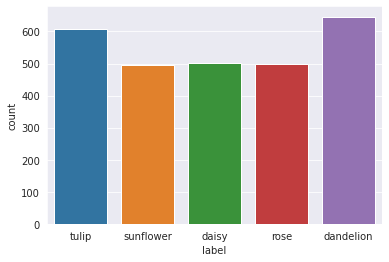

In [ ]:
import seaborn as sns
sns.set_style('darkgrid')
sns.countplot(train['label'])

In [ ]:
train.to_csv("/content/content/flowers/train.csv",index=False)

In [ ]:
path= '/content/content/flowers/train'
tfms = get_transforms(flip_vert=False,max_zoom=1.0,max_warp=0,do_flip=False,xtra_tfms=[cutout()])
data = (ImageList.from_csv(path, csv_name = '/content/content/flowers/train.csv')
        .split_by_rand_pct()              
        .label_from_df()            
        .add_test_folder(test_folder = '/content/content/flowers/test')              
        .transform(tfms, size=224)
        .databunch(num_workers=0,bs=8))

In [ ]:
val=data.classes
print(val)

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


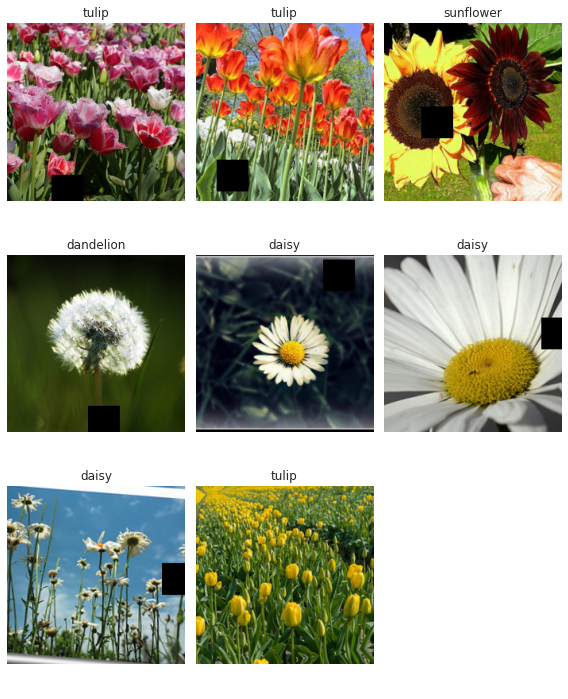

In [ ]:
## to see the images in train with there labels
data.show_batch(rows=3, figsize=(8,10))

In [ ]:
print(data.classes)

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


In [ ]:
path= '/content/content/flowers/train'
k= '/content/content/flowers/train.csv'
p ='/content/content/flowers/Testing_set_flower.csv'

In [ ]:
learn = cnn_learner(data, models.densenet121, metrics=[error_rate, accuracy], model_dir="/tmp/model/")

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


In [ ]:
from fastai import *
from fastai.vision import *
from sklearn.model_selection import StratifiedKFold
from pathlib import Path
import shutil
from sklearn.metrics import f1_score, confusion_matrix

np.random.seed(1786)
ROOT = "/content/content/flowers"

In [ ]:
def read_data(root):
    train_df = pd.read_csv(k)
    test_df = pd.read_csv(p)
    return train_df, test_df

In [ ]:
class SaveBestModel(Recorder):
    def __init__(self, learn,name='best_model'):
        super().__init__(learn)
        self.name = name
        self.best_loss = None
        self.best_acc = None
        self.save_method = self.save_when_acc
        
    def save_when_acc(self, metrics):        
        loss, acc = metrics[0], metrics[1]
        if (self.best_acc is None) or (acc > self.best_acc) or (loss < self.best_loss):
            self.best_acc = acc
            self.best_loss = loss
            self.learn.save(f'{self.name}')
            print("Save the best acc {:.5f}".format(self.best_acc))
        elif acc == self.best_acc and  loss < self.best_loss:
            self.best_loss = loss
            self.learn.save(f'{self.name}')
            print("Acc is eq,Save the lower loss {:.5f}".format(self.best_loss))
            
    def on_epoch_end(self,last_metrics=MetricsList,**kwargs:Any):
        self.save_method(last_metrics)

In [ ]:
if __name__=="__main__":
    train_df, test_df = read_data(ROOT)
    print(train_df.shape, test_df.shape)
    
    cvlist = list(StratifiedKFold(16, random_state=12345786).split(train_df, train_df.label))
    
    tfms1 = get_transforms(max_zoom=2.0)
    test_preds_all = []
    val_preds_all = []
    for i in range(2):
        print("Starting fold {}".format(i))
        tr_idx, val_idx = cvlist[i]
        print(tr_idx.shape, val_idx.shape)
        src = (ImageList.from_df(train_df, path=ROOT, folder="train").split_by_idxs(tr_idx, val_idx)
                                                            .label_from_df())
        data = ImageDataBunch.create_from_ll(src, ds_tfms=tfms1, size=224, bs=32, resize_method=3).normalize(imagenet_stats)
        data.add_test(ImageList.from_df(test_df, path=ROOT, folder="test"))
        learn = cnn_learner(data, models.resnet152, metrics=accuracy, ps=0.5)
        # learn.model[0].load_state_dict(torch.load("../input/save-body-weights-marvel/bestmodel_body.path"))
        cb = SaveBestModel(learn, name="bestmodel_{}".format(i))
        # learn.fit(1, callbacks=cb)
        learn.fit_one_cycle(4)
        learn.unfreeze()
        learn.fit_one_cycle(3, max_lr=1e-4, callbacks=[cb])
        learn.fit_one_cycle(2, max_lr=5e-5, callbacks=[cb])
        learn.fit_one_cycle(1, max_lr=1e-5, callbacks=[cb])
        learn.fit_one_cycle(1, max_lr=5e-6, callbacks=[cb])
        learn.fit_one_cycle(2, max_lr=1e-6, callbacks=[cb])
        learn.load("bestmodel_{}".format(i))
        val_preds, y = learn.TTA(ds_type=DatasetType.Valid)
        val_preds = np.exp(val_preds.numpy())
        print("F1 score for this fold ",f1_score(y.numpy(), np.argmax(val_preds,axis=1), average='weighted'))
        test_preds = np.exp(learn.TTA(ds_type=DatasetType.Test)[0].numpy())
        test_preds_all.append(test_preds)
        val_preds_all.append(val_preds)
        fname = "bestmodel_{}.pth".format(i)
        src = str(Path(ROOT) / "models" / fname)
        shutil.copy(src, fname)
    test_preds_all = np.mean(test_preds_all, axis=0)
    val_preds_all = np.concatenate(val_preds_all, axis=0)

    np.save("test_preds.npy", test_preds_all)
    np.save("val_preds.npy", val_preds_all)


(2746, 2) (924, 1)
Starting fold 0
(2574,) (172,)


Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/hub/checkpoints/resnet152-b121ed2d.pth


epoch,train_loss,valid_loss,accuracy,time
0,0.790632,0.423960,0.866279,00:30
1,0.496724,0.254922,0.912791,00:29
2,0.324326,0.201350,0.936047,00:29
3,0.233688,0.195891,0.930233,00:29


epoch,train_loss,valid_loss,accuracy,time
epoch,train_loss,valid_loss,accuracy,time
0,0.215393,0.396411,0.936047,00:37
1,0.249842,0.203419,0.912791,00:37
2,0.155675,0.099314,0.965116,00:37


Save the best acc 0.93605
Save the best acc 0.91279
Save the best acc 0.96512


epoch,train_loss,valid_loss,accuracy,time
epoch,train_loss,valid_loss,accuracy,time
0,0.111038,0.075289,0.970930,00:37
1,0.100257,0.046802,0.982558,00:37


Save the best acc 0.97093
Save the best acc 0.98256


epoch,train_loss,valid_loss,accuracy,time
epoch,train_loss,valid_loss,accuracy,time
0,0.082206,0.047953,0.982558,00:37


epoch,train_loss,valid_loss,accuracy,time
epoch,train_loss,valid_loss,accuracy,time
0,0.069849,0.038016,0.988372,00:37


Save the best acc 0.98837


epoch,train_loss,valid_loss,accuracy,time
epoch,train_loss,valid_loss,accuracy,time
0,0.080907,0.041079,0.988372,00:38
1,0.074892,0.035903,0.988372,00:37


Save the best acc 0.98837


F1 score for this fold  0.9941734149713609


Starting fold 1
(2574,) (172,)


epoch,train_loss,valid_loss,accuracy,time
0,0.720831,0.702307,0.872093,00:29
1,0.489729,0.404565,0.854651,00:29
2,0.310054,0.430285,0.866279,00:29
3,0.210878,0.435164,0.860465,00:29


epoch,train_loss,valid_loss,accuracy,time
epoch,train_loss,valid_loss,accuracy,time
0,0.310152,0.810520,0.808140,00:37
1,0.232606,0.290686,0.895349,00:37
2,0.168065,0.239705,0.918605,00:37


Save the best acc 0.80814
Save the best acc 0.89535
Save the best acc 0.91860


epoch,train_loss,valid_loss,accuracy,time
epoch,train_loss,valid_loss,accuracy,time
0,0.104217,0.273605,0.918605,00:37
1,0.086392,0.219486,0.906977,00:37


Save the best acc 0.90698


epoch,train_loss,valid_loss,accuracy,time
epoch,train_loss,valid_loss,accuracy,time
0,0.067064,0.233392,0.924419,00:37


Save the best acc 0.92442


epoch,train_loss,valid_loss,accuracy,time
epoch,train_loss,valid_loss,accuracy,time
0,0.077026,0.228843,0.924419,00:37


Save the best acc 0.92442


epoch,train_loss,valid_loss,accuracy,time
epoch,train_loss,valid_loss,accuracy,time
0,0.078442,0.238000,0.918605,00:37
1,0.075023,0.236322,0.918605,00:37


F1 score for this fold  0.9183726357297025


In [ ]:
x = np.argmax(test_preds, axis=1)
x

array([3, 3, 1, 2, ..., 0, 1, 1, 0])

In [ ]:
val

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [ ]:
f=[]
for i in x:
  f.append(val[i])

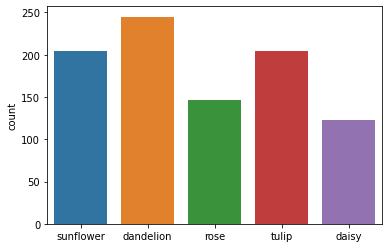

In [ ]:
sns.countplot(f)

## Save Predictions

In [ ]:
res = pd.DataFrame({'filename': test['filename'], 'prediction': f}) # prediction is nothing but the final predictions of your model on input features of your new unseen test data
res[['prediction']].to_csv("submission_resnet152_dphi25.csv", index = False) # the csv file will be saved locally on the same location where this notebook is located.

**densenet121 submission scores : 94.37229437229438**

**resnet152 submision scores : 95.12987012987013**

## Image Classification using Keras

In [ ]:
!pip install albumentations

     |████████████████████████████████| 634kB 6.8MB/s 
  Created wheel for imgaug: filename=imgaug-0.2.6-cp37-none-any.whl size=654019 sha256=f2a84f2ebb8e801bbddbae0916b47ee1b4275efbb2432dbdc5667c98c1f3ea3f
  Stored in directory: /root/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built imgaug
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9


In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
#
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,Flatten,GlobalAveragePooling2D,AveragePooling2D,Dropout,BatchNormalization
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.regularizers import *
from tensorflow.keras.applications import DenseNet121,ResNet152
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,EarlyStopping

#
import albumentations as A

In [ ]:
train.head()

,filename,label
0,tulip/14068378204_7b26baa30d_n.jpg,tulip
1,tulip/6325571510_7544b27e57_n.jpg,tulip
2,tulip/16098264209_38fe491093.jpg,tulip
3,tulip/14068200854_5c13668df9_m.jpg,tulip
4,tulip/5208680166_c4372477ef_n.jpg,tulip


In [ ]:
test.head()

,filename
0,Image_1.jpg
1,Image_2.jpg
2,Image_3.jpg
3,Image_4.jpg
4,Image_5.jpg


## Display Image

In [ ]:
image = cv2.imread("/content/content/flowers/train/daisy/10140303196_b88d3d6cec.jpg")
image.shape

(313, 500, 3)

In [ ]:
image_res = cv2.resize(image,(300,300))

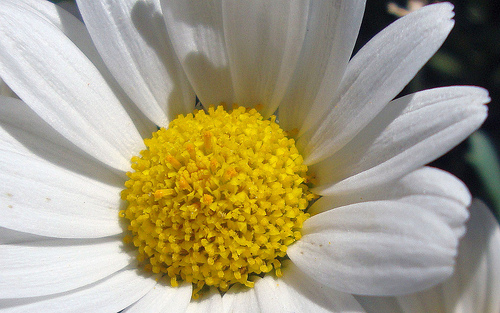

In [ ]:
from google.colab.patches import cv2_imshow
cv2_imshow(image)

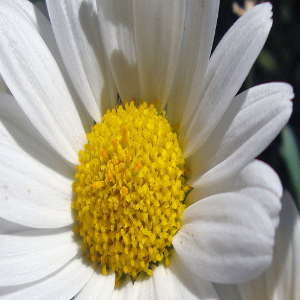

In [ ]:
cv2_imshow(image_res)

## Image Augmentation

In [ ]:
train_datagen = ImageDataGenerator(width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   zoom_range=0.3,
                                   fill_mode="nearest",
                                   horizontal_flip = True,
                                   rescale=1./255 )

## Auxillary Function for getting model name

In [ ]:
def get_model_name(k):
  return "model_"+str(k)+".h5"

In [ ]:
import tensorflow
data_augmentation = Sequential([tensorflow.keras.layers.experimental.preprocessing.CenterCrop(224,224)])

In [ ]:
inputs = tensorflow.keras.Input(shape=(229,229,3))
tensor_x = data_augmentation(inputs)
resnet = ResNet152(weights="imagenet",input_tensor=tensor_x)
x = resnet.layers[-2].output

242900992/242900224 [==============================] - 2s 0us/step


In [ ]:
fc1 = Dense(5,kernel_initializer="glorot_uniform",
            kernel_regularizer=l2(0.0005),
            activation="softmax"
            )(x)

In [ ]:
my_model = Model(inputs=resnet.input,outputs=fc1)

In [ ]:
my_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 229, 229, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           sequential[0][0]                 
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
______________________________________________________________________________________________

In [ ]:
save_dir = "/content/content/saved_models"

In [ ]:
fold_var=1

## Define Callbacks

In [ ]:
my_callbacks = [ModelCheckpoint(save_dir+get_model_name(fold_var),
                                monitor='val_accuracy',
                                verbose=1,
                                save_best_only=True,
                                mode='max'),
                EarlyStopping(monitor="val_accuracy",
                              patience=3,
                              verbose=0,
                              mode="max"),
                ReduceLROnPlateau(monitor="val_loss",
                                  factor=0.1,
                                  patience=5,
                                  verbose=1,
                                  mode="min",
                                  min_delta=1e-4)]

In [ ]:
cvlist = StratifiedKFold(5, random_state=42,shuffle=True)

In [ ]:
validation_accuracy = []
validation_loss =[]
X = train['filename']
Y = train['label']
for train_index,test_index in cvlist.split(X,Y):
  train_data,test_data = train.iloc[train_index],train.iloc[test_index]
  train_data_generator = train_datagen.flow_from_dataframe(dataframe=train_data,
                                                           directory="/content/content/flowers/train",
                                                           x_col ="filename",
                                                           y_col = "label",
                                                           class_mode="categorical",
                                                           shuffle=True)
  valid_data_generator = train_datagen.flow_from_dataframe(dataframe=test_data,
                                                           directory="/content/content/flowers/train",
                                                           x_col ="filename",
                                                           y_col = "label",
                                                           class_mode="categorical",
                                                           shuffle=True)
  #
  model = my_model
  #
  model.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.00001,decay=0.0001),
                metrics=['accuracy'],
                loss="categorical_crossentropy")
  #
  step_size_train = train_data_generator.n//train_data_generator.batch_size
  step_size_valid = train_data_generator.n//valid_data_generator.batch_size
  #
  history = model.fit(train_data_generator,
                      steps_per_epoch=step_size_train,
                      epochs=10,
                      validation_data=valid_data_generator,
                      validation_steps=step_size_valid,
                      callbacks=[my_callbacks])
  model.load_weights("/content/content/saved_models/model_"+str(fold_var)+".h5")
  results = model.evaluate(valid_data_generator)
  results = dict(zip(model.metrics_names,results))
  validation_accuracy.append(results['accuracy'])
  validation_loss.append(results['loss'])
  tensorflow.keras.backend.clear_session()
  fold_var +=1

Found 2196 validated image filenames belonging to 5 classes.
Found 550 validated image filenames belonging to 5 classes.
Epoch 1/10
68/68 [==============================] - 74s 836ms/step - loss: 0.3092 - accuracy: 0.9029 - val_loss: 2.0160 - val_accuracy: 0.2364

Epoch 00001: val_accuracy improved from -inf to 0.23636, saving model to /content/content/saved_modelsmodel_1.h5
Epoch 2/10
68/68 [==============================] - 54s 792ms/step - loss: 0.1947 - accuracy: 0.9433 - val_loss: 2.2583 - val_accuracy: 0.2382

Epoch 00002: val_accuracy improved from 0.23636 to 0.23818, saving model to /content/content/saved_modelsmodel_1.h5
Epoch 3/10
68/68 [==============================] - 53s 781ms/step - loss: 0.1194 - accuracy: 0.9690 - val_loss: 2.1107 - val_accuracy: 0.2618

Epoch 00003: val_accuracy improved from 0.23818 to 0.26182, saving model to /content/content/saved_modelsmodel_1.h5
Epoch 4/10
68/68 [==============================] - 53s 779ms/step - loss: 0.0913 - accuracy: 0.9785 -